# 02 - Data from the Web


In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [1]:
from bs4 import BeautifulSoup
import requests
import json
import string
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import unicodedata
from textblob.blob import TextBlob

%matplotlib inline

# Methods

## Ratio calculation

In [2]:
def ratio(a, b):
    if np.isnan(a)|np.isnan(b)|(b == 0):
        return np.nan
    else:
        return a/b

# Task 1 - Data from QS ranking

## Question 1 : Data from www.topuniversities.com 

Multiple strategies have been testes in order to find the data used to construct the table of the QS Rankings. However, only one of them led to the expected result. We opened the Web Inspector on the website. Among the ressources used by the page, a text file named 'XHR/357051.txt'  was containing the expected ranking with the desired informations. 

In [3]:
URL_QS = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508497791260'
r = requests.get(URL_QS)
page_body = r.json()
qs_df = pd.DataFrame(page_body['data'])
qs_df = qs_df.drop(['core_id','logo','guide','cc', 'nid', 'stars','score'], axis = 1).head(200)

Additionnal informations needed to be accessed on each university webpage. We used the 'url' column, went to the university page and extracted all the number values we wanted and placed them in additionnal columns. In some cases, there were no informations on the webpage, in this case the columns are filed with NaN.

In [4]:
# Going on each university page for each index of the table

for index_ in range(0, qs_df.shape[0]):
    
    URL_ADD = 'https://www.topuniversities.com' + qs_df.get_value(index_, 'url')
    r = requests.get(URL_ADD)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    # Request all numbers that are displayed on the page, we know their order
    all_numbers = soup.findAll('div', {'class' : 'number'})
    
    # If the page contains no numbers, we will store NaN
    if not all_numbers:
        total_faculty_number = np.nan
        interna_faculty_number = np.nan
        total_students_number = np.nan
        interna_students_number = np.nan
   
    else:    
    # Total Faculty Members
        total_faculty = all_numbers[0]
        total_faculty_number = int(re.sub("[^\\d]",'',str(total_faculty)))
    
    # International Faculty Members
        interna_faculty = all_numbers[1]
        interna_faculty_number = int(re.sub("[^\\d]",'',str(interna_faculty)))
    
    # Total Students
        total_students = all_numbers[2]
        total_students_number = int(re.sub("[^\\d]",'',str(total_students)))  
    
    # International Students
        if all_numbers[3] == all_numbers[0]:
            interna_students_number = np.nan
        else:
            interna_students = all_numbers[3]
            interna_students_number = int(re.sub("[^\\d]",'',str(interna_students)))
    
    # Adding the found values in the columns
    qs_df.set_value(index_, 'Faculty Members - Total', total_faculty_number)
    qs_df.set_value(index_, 'Faculty Members - International', interna_faculty_number)
    qs_df.set_value(index_, 'Nb Students - Total', total_students_number)
    qs_df.set_value(index_, 'Nb Students - International', interna_students_number)

### Internationnal/Total students and Studients staff Ratio computation

In [5]:
for index, row in qs_df.iterrows():
    if np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Nb Students - International']) or np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Faculty Members - Total']):
        qs_df.loc[index, 'QS Ratio Int. Students'] = round(ratio(row['Nb Students - International'], row['Nb Students - Total']), 2)
        qs_df.loc[index, 'QS Ratio Students/Staff'] = round(ratio(row['Nb Students - Total'], row['Faculty Members - Total']), 2)


In [6]:
qs_df = qs_df.loc[ :, ['title', 'rank_display', 'country', 'region', 'QS Ratio Int. Students', 'QS Ratio Students/Staff' ]]


In [7]:
qs_df = qs_df.rename(index=str, columns={ "title" : "University", "rank_display": "QS rank"});

In [8]:
qs_df.index = np.arange(1, len(qs_df) + 1)
qs_df['QS rank'] = qs_df.index.values.tolist()

In [9]:
qs_df.head(200)

,University,QS rank,country,region,QS Ratio Int. Students,QS Ratio Students/Staff
1,Massachusetts Institute of Technology (MIT),1,United States,North America,0.34,3.71
2,Stanford University,2,United States,North America,0.23,3.71
3,Harvard University,3,United States,North America,0.23,5.16
4,California Institute of Technology (Caltech),4,United States,North America,0.29,2.37
5,University of Cambridge,5,United Kingdom,Europe,0.36,3.42
6,University of Oxford,6,United Kingdom,Europe,0.37,2.92
7,UCL (University College London),7,United Kingdom,Europe,0.48,4.90
8,Imperial College London,8,United Kingdom,Europe,0.54,4.09
9,University of Chicago,9,United States,North America,0.25,5.54
10,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,0.38,8.00


In [10]:
max_internatio_ratio_index = qs_df['QS Ratio Int. Students'].argmax()
max_internatio_ratio = qs_df['QS Ratio Int. Students'][max_internatio_ratio_index]

max_stud_staff_ratio_index = qs_df['QS Ratio Students/Staff'].argmax()
max_stud_staff_ratio = qs_df['QS Ratio Students/Staff'][max_stud_staff_ratio_index]


print("The university with the biggest International studient ration is the", qs_df.University[max_internatio_ratio_index],
      "with a ratio of ", max_internatio_ratio, "\n\n")

print("The university with the biggest studients/staff ratio is the", qs_df.University[max_stud_staff_ratio_index],
      "with a ratio of ", max_stud_staff_ratio, "\n\n")

The university with the biggest International studient ration is the London School of Economics and Political Science (LSE) with a ratio of  0.69 


The university with the biggest studients/staff ratio is the Vienna University of Technology with a ratio of  24.76 




### Plot the results

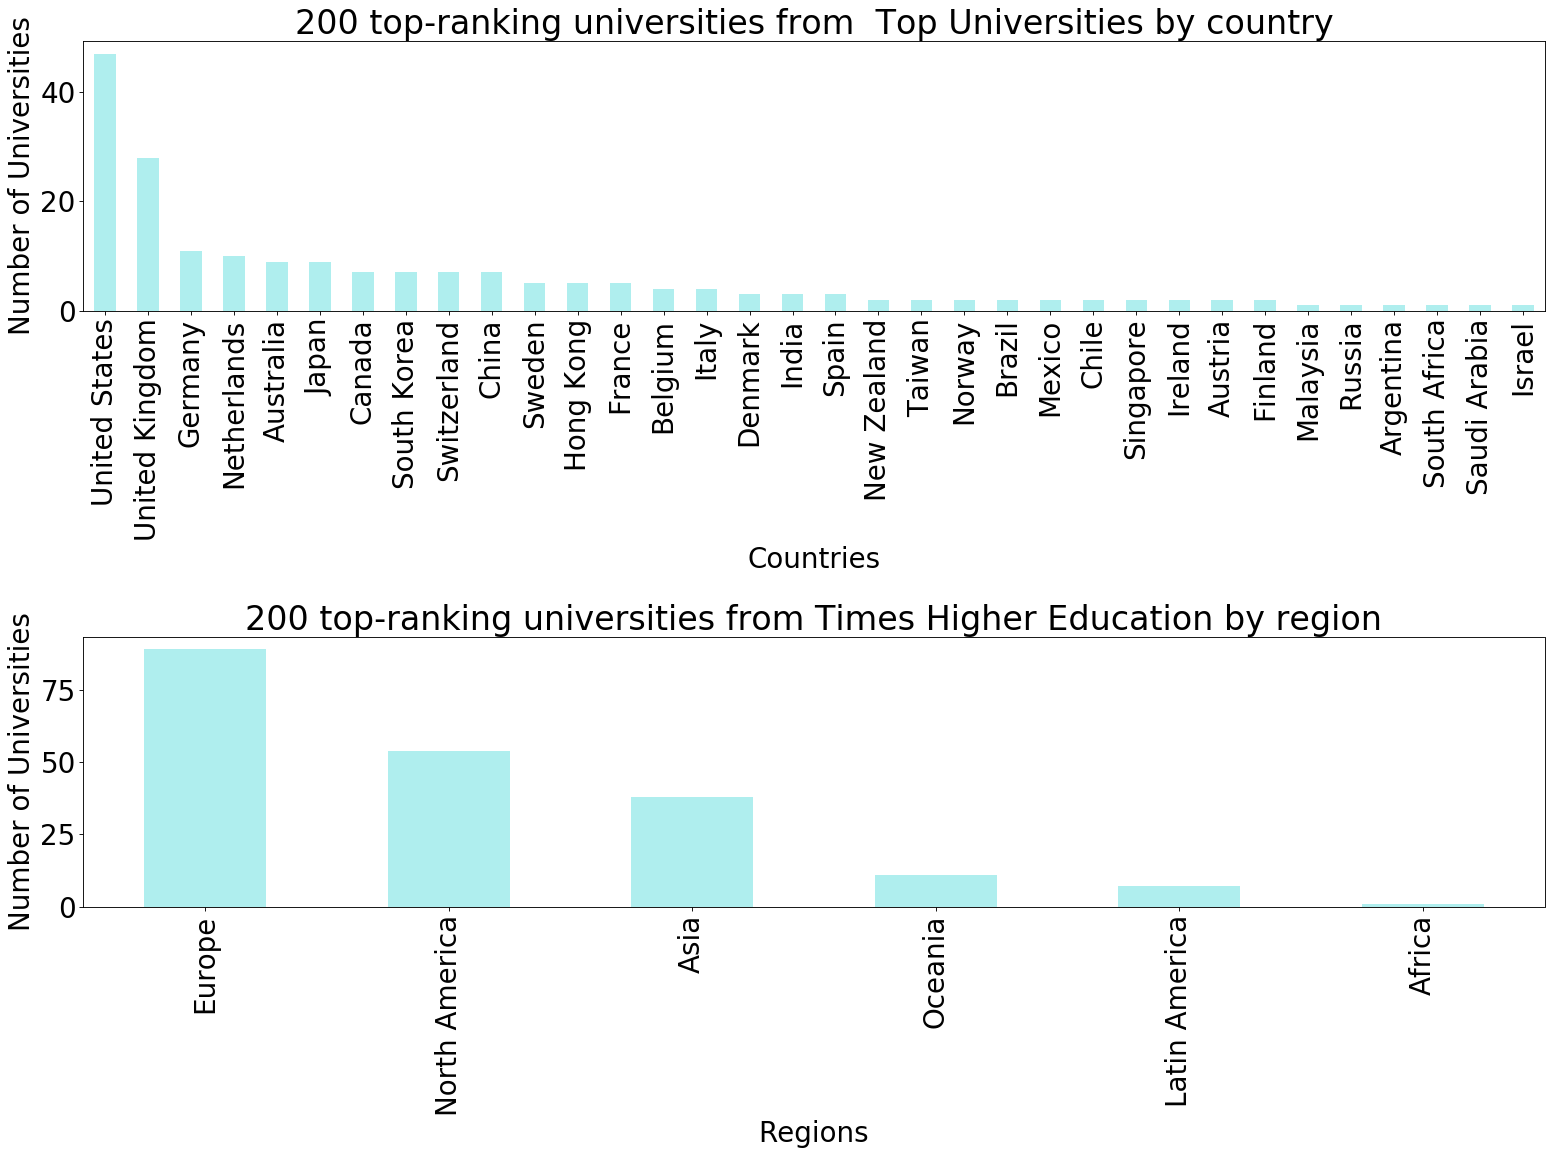

In [46]:
fig = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.subplot(2,1,1)
embarkedPlot = qs_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from  Top Universities by country')

plt.subplot(2, 1, 2)
embarkedPlot = qs_df['region'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Regions")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Times Higher Education by region')


fig.tight_layout()

plt.show()

## Question 2 : Data from www.timeshighereducation.com

In [12]:
URL_THE = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL_THE)
page_body = r.json()
the_df = pd.DataFrame(page_body['data'])

### Clean the data

In [13]:
# We only take the 200 first univercity
the_df = the_df[:200]

In [14]:
the_df.head()

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


Lot of informations are useless in our case, we only take the following :
- name
- location
- rank
- stats number students
- stats % intl students (to rename and maybe change the percentage by a number)
- stat student staff ratio


#### We calculate the number of International students and then the ratio

In [15]:
# Firts we need to remove the '%' symbol from the column "THE % International Students"
# Then we convert the string to int and we do the calculation

the_df['stats_number_students'] = pd.to_numeric(the_df['stats_number_students'].str.replace(',', ''))
the_df['stats_pc_intl_students'] = pd.to_numeric(the_df['stats_pc_intl_students'].str.replace('%', ''))

for index, row in the_df.iterrows():
    the_df.loc[index, 'stats_pc_intl_students'] = round(row['stats_number_students']*row['stats_pc_intl_students']*0.01)
    the_df.loc[index, 'THE Ratio Int. Students'] = round(float(row['stats_pc_intl_students'])/100.0, 2)


In [16]:
the_df = the_df.loc[ :, ['name', 'rank', 'location','THE Ratio Int. Students', 'stats_student_staff_ratio']]


#### We rename the Data in order to combine the two DF later

In [17]:
the_df = the_df.rename(index=str, columns={ "name" : "University",
                                  "rank": "THE rank", "location": "country",
                                  "stats_student_staff_ratio" : "THE Ratio Students/Staff"
                                 });

In [18]:
the_df.index = np.arange(1, len(the_df) + 1) 
the_df['THE rank'] = the_df.index.values.tolist()

In [19]:
qs_df.head(200)

,University,QS rank,country,region,QS Ratio Int. Students,QS Ratio Students/Staff
1,Massachusetts Institute of Technology (MIT),1,United States,North America,0.34,3.71
2,Stanford University,2,United States,North America,0.23,3.71
3,Harvard University,3,United States,North America,0.23,5.16
4,California Institute of Technology (Caltech),4,United States,North America,0.29,2.37
5,University of Cambridge,5,United Kingdom,Europe,0.36,3.42
6,University of Oxford,6,United Kingdom,Europe,0.37,2.92
7,UCL (University College London),7,United Kingdom,Europe,0.48,4.90
8,Imperial College London,8,United Kingdom,Europe,0.54,4.09
9,University of Chicago,9,United States,North America,0.25,5.54
10,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,0.38,8.00


In [20]:
max_internatio_ratio_index = the_df['THE Ratio Int. Students'].argmax()
max_internatio_ratio = the_df['THE Ratio Int. Students'][max_internatio_ratio_index]

max_stud_staff_ratio_index = the_df['THE Ratio Students/Staff'].argmax()
max_stud_staff_ratio = the_df['THE Ratio Students/Staff'][max_stud_staff_ratio_index]


print("The university with the biggest International studient ration is the", the_df.University[max_internatio_ratio_index],
      "with a ratio of ", max_internatio_ratio, "\n\n")

print("The university with the biggest studients/staff ratio is the", the_df.University[max_stud_staff_ratio_index],
      "with a ratio of ", max_stud_staff_ratio, "\n\n")

The university with the biggest International studient ration is the London School of Economics and Political Science with a ratio of  0.71 


The university with the biggest studients/staff ratio is the Cornell University with a ratio of  9.8 




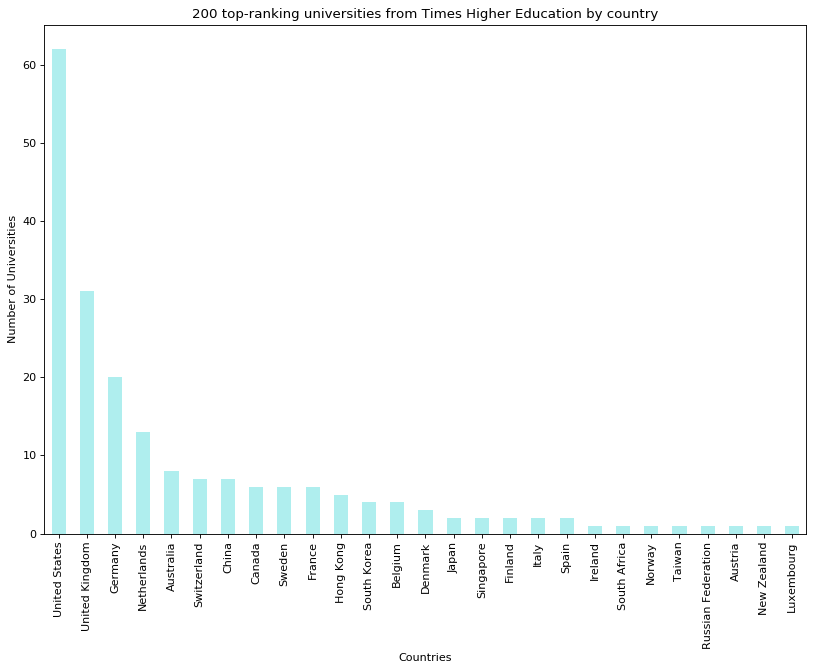

In [21]:
fig2 = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2,2,1)
embarkedPlot = the_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Times Higher Education by country')

#plt.subplot(2, 2, 2)
#embarkedPlot = the_df['region'].value_counts().plot(kind='bar', color='paleturquoise')
#embarkedPlot.set_xlabel("Regions")
#embarkedPlot.set_ylabel("Number of Universities")
#plt.title('FIND TITLE')


fig2.tight_layout()

plt.show()

## Question 3 : Data Merging


#### Avant de faire ça il faut cleaner les nom. 
Certains noms sont dans la langue naturelle pas en anglais. Il faut traduire
On prend les deux colonnes d'Université, on check si les noms du classement de THE sont dans QS, si oui on renomme QS avec le nom de THE.
Bon complexité de merde, mais ça ira pour l'instant, le Dataset étant pas trop gros

In [22]:
for index_qs, row_qs in qs_df.iterrows():
     for index_the, row_the in the_df.iterrows():
        if row_the['University'] in row_qs['University'] :
            qs_df.loc[index_qs, 'University'] = row_the['University']


In [23]:
def remove_acronyme(column, df):
    for index, row in df.iterrows():
        a = row[column].find('(')
        if a != -1:
            df.loc[index, column] = row[column][:a-1]
remove_acronyme('University', qs_df)     

We have to remove accents "é" because they are problematic for the merging


In [25]:
# Remove accents for  www.topuniversities.com

for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        qs_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))

In [27]:
# Remove accent for www.timeshighereducation.com

for index, row in the_df.iterrows():
    #the_df.loc[index, 'University'] = row['University'].replace('of','')
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        the_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))

#### Translation

In [29]:
for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'ca', 'la', 'fr']:
        #print(row['University'])
        #print(en_blob.detect_language())
        a = en_blob.translate(to='en')
        qs_df.loc[index, 'University'] = str(a)
        
for index, row in the_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'la', 'fr']:
        print(row['University'])
        print(en_blob.detect_language())
        a = en_blob.translate(to='en')
        the_df.loc[index, 'University'] = str(a)

Ecole Polytechnique Federale de Lausanne
fr
Paris Sciences et Lettres – PSL Research University Paris
fr
Ecole Polytechnique
fr
Charité - Universitätsmedizin Berlin
de
Universite Catholique de Louvain
fr
TU Dresden
de
Universite Libre de Bruxelles
fr
Ecole Normale Superieure de Lyon
fr


### Enlever des mots

In [30]:
#for ( index_qs, row_qs ), ( index_the, row_the ) in zip( qs_df.iterrows(), the_df.iterrows() ) :
 

### Result DataFrame

In [31]:
result = pd.merge(qs_df, the_df, how='outer', on='University')

In [32]:
result = result.drop(['country_x'], axis=1)
result = result.rename(index=str, columns={ "country_y" : "Country"});

In [33]:
result = pd.concat([result.filter(like='University'),
                  result.filter(items=['Country', 'region']), result.filter(like='rank'), 
                  result.filter(like='Ratio Int. Students'), result.filter(like='Ratio Students/Staff')],  
                  axis=1,  
                  keys=('University', 'Location', 'Rank','Ratio Int. Students', 'Ratio Students/Staff'))

In [35]:
result = result.rename(index=str, columns={ "QS rank" : "QS", "THE rank" : "THE", 'QS Ratio Int. Students': 'QS',
                                          'THE Ratio Int. Students': 'THE', 'QS Ratio Students/Staff' : 'QS',
                                          'THE Ratio Students/Staff' : 'THE'});

In [36]:
result.to_csv('result.csv')

In [37]:
result.head()

University        Location                Rank  \
                              University         Country         region   QS   
0  Massachusetts Institute of Technology   United States  North America  1.0   
1                    Stanford University   United States  North America  2.0   
2                     Harvard University   United States  North America  3.0   
3     California Institute of Technology   United States  North America  4.0   
4                University of Cambridge  United Kingdom         Europe  5.0   

       Ratio Int. Students       Ratio Students/Staff        
   THE                  QS   THE                   QS   THE  
0  5.0                0.34  0.34                 3.71   8.7  
1  4.0                0.23  0.22                 3.71   7.5  
2  6.0                0.23  0.26                 5.16   8.9  
3  3.0                0.29  0.27                 2.37   6.5  
4  2.0                0.36  0.35                 3.42  10.9

## 4) Correlation

In [38]:
# We remplace the name of country/region for the plot

countryList = result['Location']['Country'].unique()  # List the different country
countryList = [x for x in countryList if str(x) != 'nan'] # Remove Nan values
countryDict = {k: v for v, k in enumerate(countryList)}   # Transforme to dict

regionList = result['Location']['region'].unique() 
regionList = [x for x in regionList if str(x) != 'nan']
regionDict = {k: v for v, k in enumerate(regionList)}

result_tmp = result.replace({"Location": countryDict}).replace({"Location": regionDict})
result_tmp = result_tmp.replace("No Ratio", np.nan)

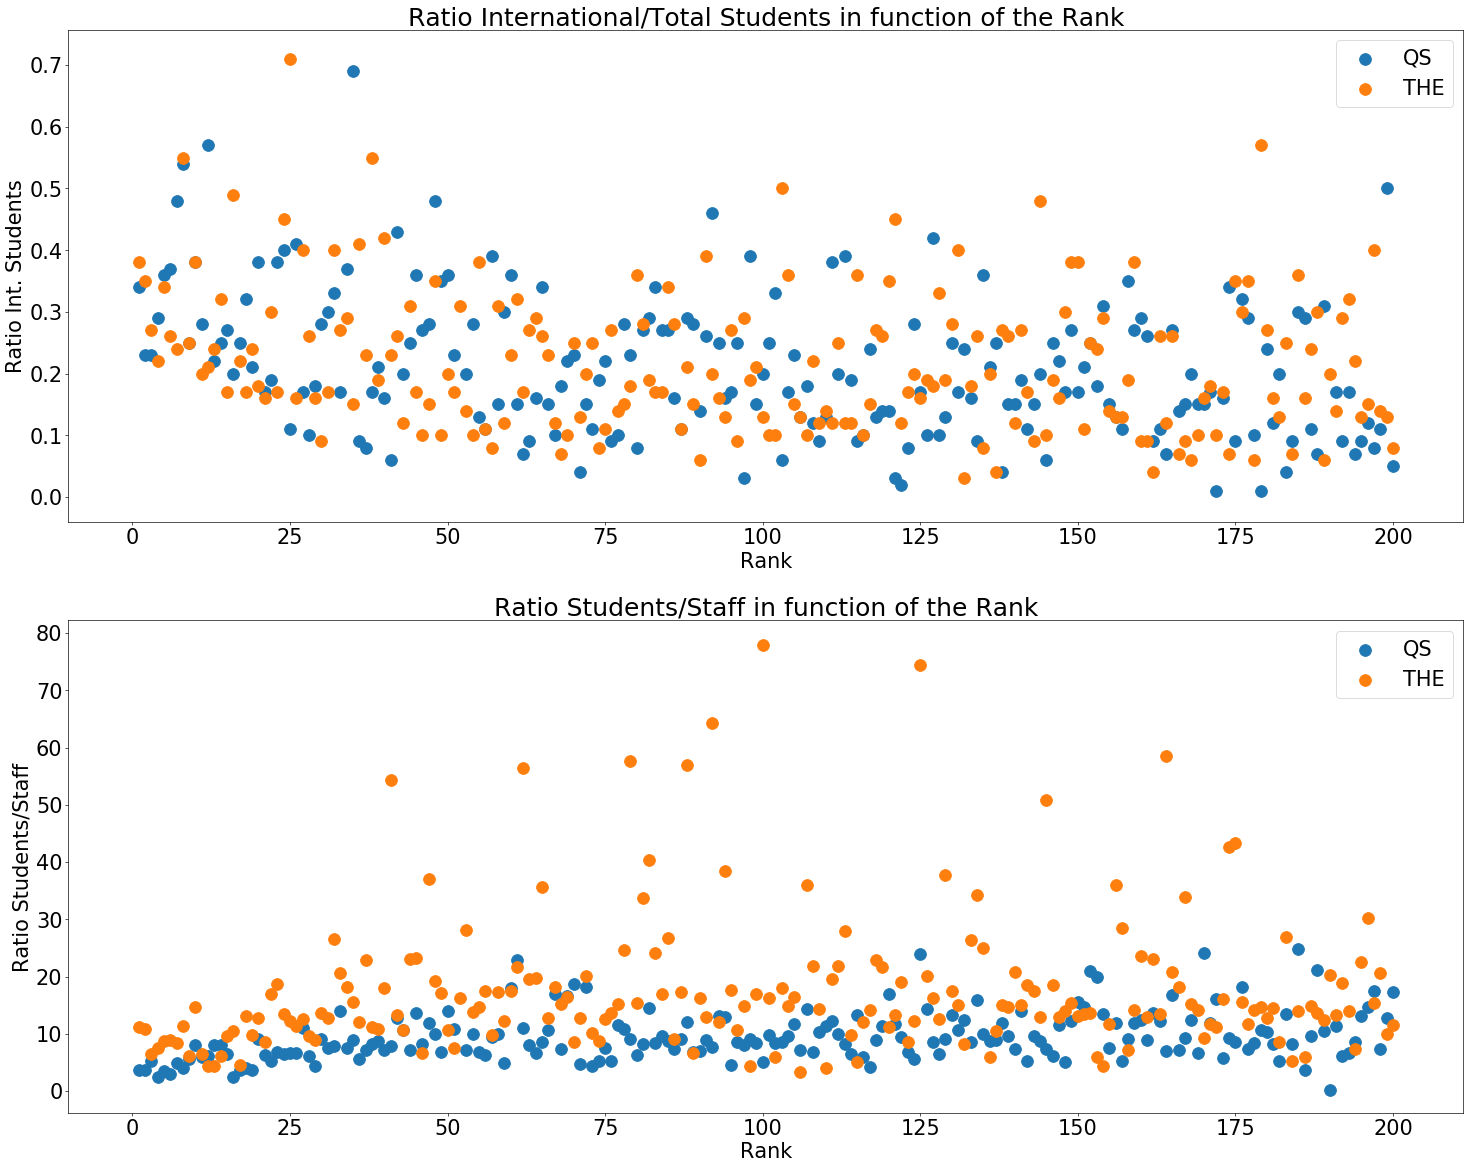

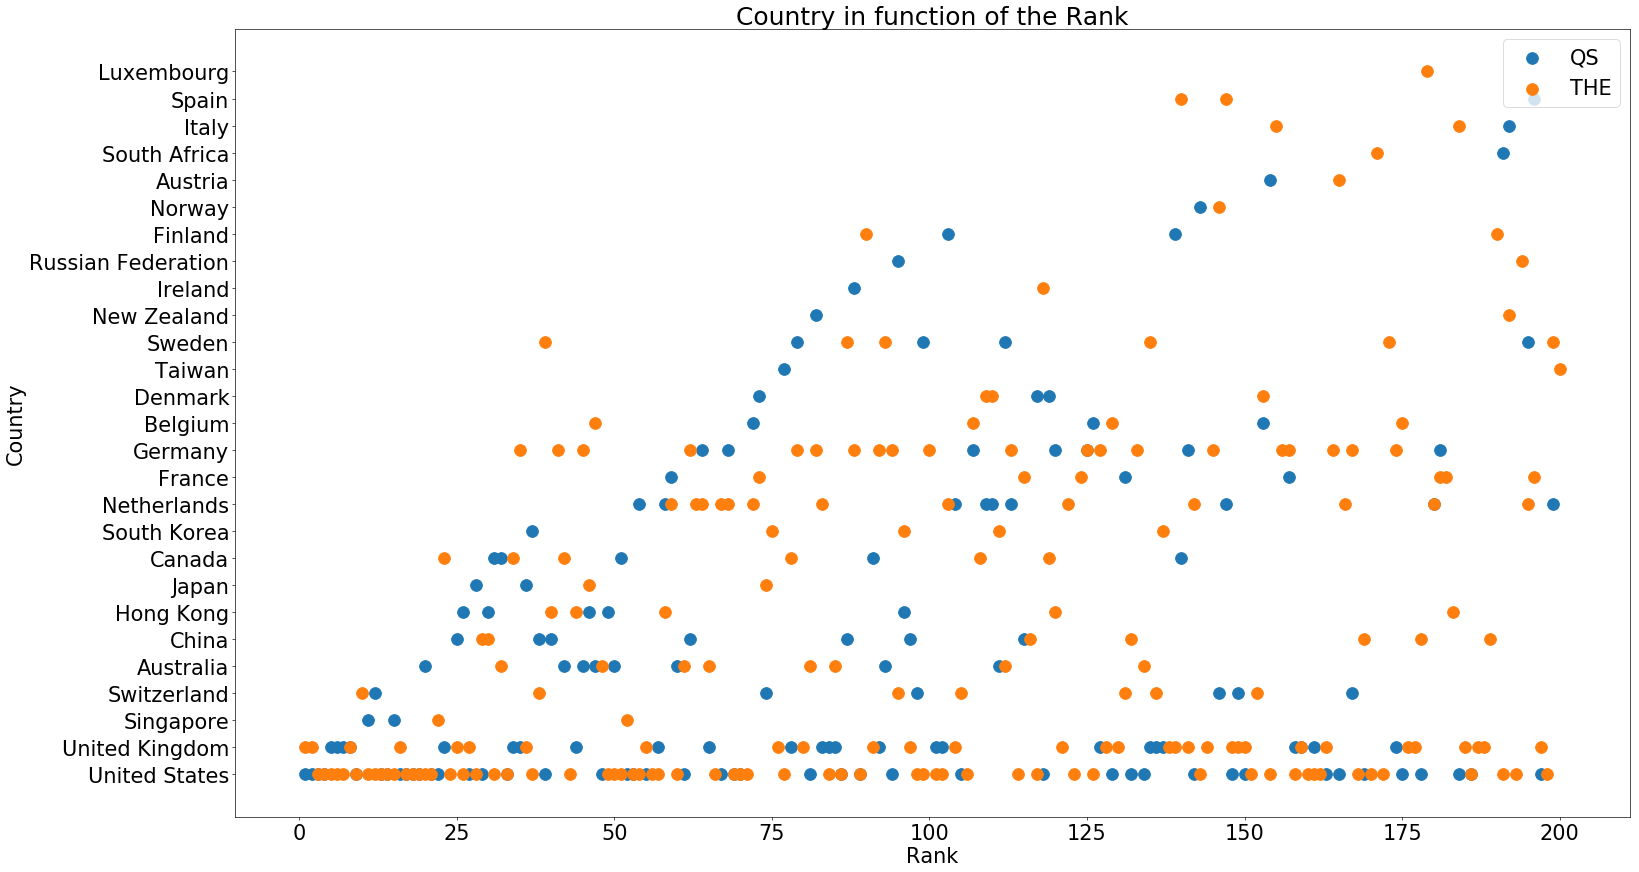

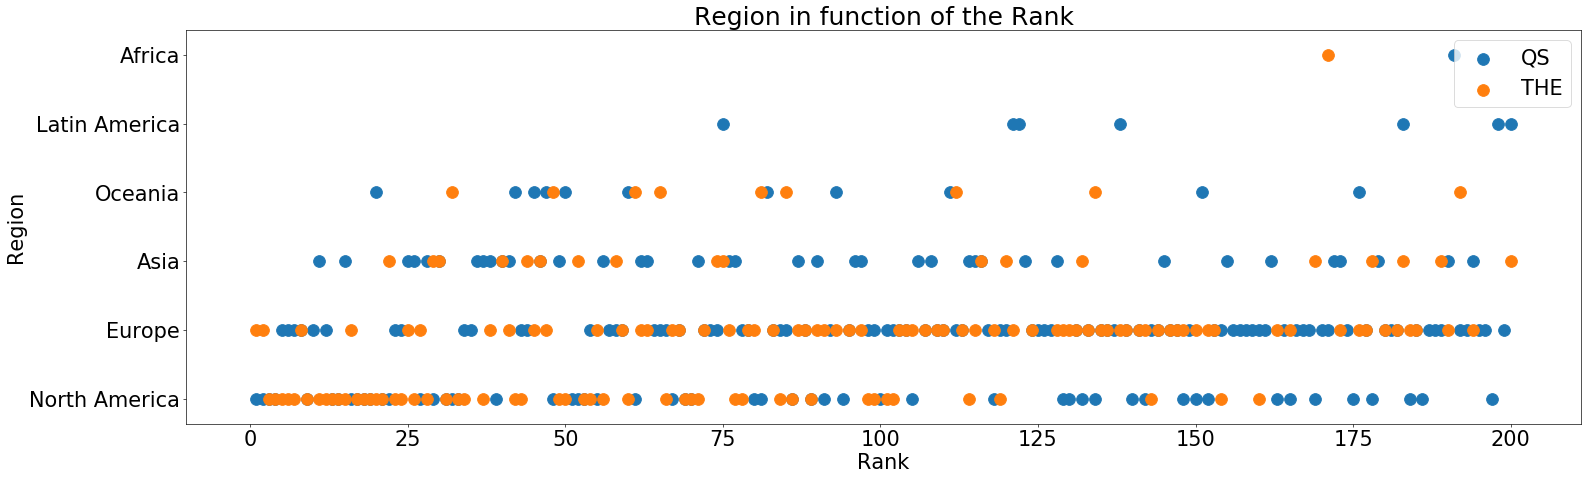

In [47]:
# Plot

plt.figure(figsize=(30, 50), dpi=60, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.subplot(4,1,1)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Ratio Int. Students']['QS'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Ratio Int. Students']['THE'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Ratio Int. Students")
plt.legend(loc='upper right');
plt.title("Ratio International/Total Students in function of the Rank")

plt.subplot(4,1,2)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Ratio Students/Staff']['QS'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Ratio Students/Staff']['THE'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Ratio Students/Staff")
plt.legend(loc='upper right');
plt.title("Ratio Students/Staff in function of the Rank")

plt.figure(figsize=(30,80), dpi= 60, facecolor='w', edgecolor='k')

plt.subplot(4,1,3)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Location']['Country'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Location']['Country'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Country")
plt.legend(loc='upper right');
plt.title("Country in function of the Rank")
plt.yticks(range(0, np.shape(countryList)[0], 1), countryList)


plt.figure(figsize=(30,40), dpi= 60, facecolor='w', edgecolor='k')

plt.subplot(4,1,4)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Location']['region'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Location']['region'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Region")
plt.legend(loc='upper right');
plt.title("Region in function of the Rank")
plt.yticks(range(0, np.shape(regionList)[0], 1), regionList)

plt.rcParams.update({'font.size': 30})

plt.show()


plt.show()

- North America : Beaucoup d'école bien placé
- Europe : beaucoup plus "spread"
- Autre : osef